# 05_06_asteroid_differential_photometry

## 필요한 모듈

이 프로젝트를 위해서는 아래의 모듈이 필요하다. 

> numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ccdproc, version_information

### 모듈 설치

1. 콘솔 창에서 모듈을 설치할 때는 아래와 같은 형식으로 입력하면 된다.

>pip install module_name==version

>conda install module_name=version

2. 주피터 노트북(코랩 포함)에 설치 할 때는 아래의 셀을 실행해서 실행되지 않은 모듈을 설치할 수 있다. (pip 기준) 만약 아나콘다 환경을 사용한다면 7행을 콘다 설치 명령어에 맞게 수정하면 된다.

### 모듈 버전 확인

아래 셀을 실행하면 이 노트북을 실행한 파이썬 및 관련 모듈의 버전을 확인할 수 있다.

In [1]:
import importlib, sys, subprocess
packages = "numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ysfitsutilpy, ysphotutilpy, ccdproc, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        print(f"**** module {pkg} is being installed")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
    else: 
        print(f"**** module {pkg} is installed")

%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

**** module numpy is installed
**** module pandas is installed
**** module matplotlib is installed
**** module scipy is installed
**** module astropy is installed
**** module astroquery is installed
**** module photutils is installed
**** module ysfitsutilpy is installed
**** module ysphotutilpy is installed
**** module ccdproc is installed
**** module version_information is installed
This notebook was generated at 2023-11-30 14:07:16 (대한민국 표준시 = GMT+0900) 


c:\Users\USER\anaconda3\envs\astro_Python_env\Lib\site-packages\ysphotutilpy\seputil.py:113: UserWarning: Package sep is not installed. Some functions will not work.
  warn("Package sep is not installed. Some functions will not work.")


0 Python     3.11.4 64bit [MSC v.1916 64 bit (AMD64)]
1 IPython    8.12.2
2 OS         Windows 10 10.0.22631 SP0
3 numpy      1.25.2
4 pandas     2.1.0
5 matplotlib 3.7.2
6 scipy      1.11.1
7 astropy    5.3
8 astroquery 0.4.6
9 photutils  1.9.0
10 ysfitsutilpy 0.2
11 ysphotutilpy 0.1.1
12 ccdproc    2.4.1
13 version_information 1.0.4


### import modules

In [2]:
#%%
from glob import glob
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ccdproc import combine, ccd_process, CCDData

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.time import Time
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

from astroquery.jplhorizons import Horizons
from astroquery.imcce import Skybot

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

import _astro_utilities
import _Python_utilities

from astropy.nddata import Cutout2D
from astropy.stats import sigma_clip, sigma_clipped_stats
from photutils.centroids import centroid_com

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn

plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
#%%
#######################################################
# read all files in base directory for processing
BASEDIR = Path("/mnt/Rdata/ASTRO_data") 
DOINGDIR = Path(BASEDIR/ "asteroid" / "RiLA600_STX-16803_-_1bin")
DOINGDIR = Path(BASEDIR/ "asteroid" / "GSON300_STF-8300M_-_1bin")

DOINGDIRs = sorted(_Python_utilities.getFullnameListOfsubDirs(DOINGDIR))

filter_str = '132AETHRA_LIGHT_-_2023-11-24_-_GSON300_STF-8300M_-_1bin'
DOINGDIRs = [x for x in DOINGDIRs if filter_str in x]
# remove = 'BIAS'
# DOINGDIRs = [x for x in DOINGDIRs if remove not in x]
# remove = 'DARK'
# DOINGDIRs = [x for x in DOINGDIRs if remove not in x]
# remove = 'FLAT'
# DOINGDIRs = [x for x in DOINGDIRs if remove not in x]

print ("DOINGDIRs: ", format(DOINGDIRs))
print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))
#######################################################

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: '\\mnt\\Rdata\\OBS_data\\asteroid\\GSON300_STF-8300M_-_1bin'

In [ ]:
def znorm(image, **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs))

def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image, **kwargs), origin='lower')

#####################################################################
# Our object (will be queried to JPL HORIZONS)
#OBJID = '2159' # 

# Observed location
LOCATION = dict(lon=127.005, lat=37.308889, elevation=101)
Suwon =  EarthLocation(lon=127.005 * u.deg, 
                                 lat=37.308889 * u.deg, 
                                 height=101 * u.m)
observatory_code = "P64"

# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')

#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
R_AP = 1.5*FWHM_INIT # Aperture radius
R_IN = 4*FWHM_INIT   # Inner radius of annulus
R_OUT = 6*FWHM_INIT  # Outer radius of annulus

Mag_UP = 17
#######################################################

In [ ]:
for DOINGDIR in DOINGDIRs[:1] :
    DOINGDIR = Path(DOINGDIR)
    print("DOINGDIR", DOINGDIR)

    ASTRESULTDIR = DOINGDIR / _astro_utilities.Asteroid_result_dir

    if str(DOINGDIR.parts[-2]) == "RiLA600_STX-16803_-_1bin" :
        DOINGDIR = DOINGDIR / _astro_utilities.reduced_nightsky_dir
    if str(DOINGDIR.parts[-2]) == "GSON300_STF-8300M_-_1bin" :
        DOINGDIR = DOINGDIR / _astro_utilities.reduced_dir

    if not ASTRESULTDIR.exists():
        os.makedirs("{}".format(str(ASTRESULTDIR)))
        print("{} is created...".format(str(ASTRESULTDIR)))
    
    fits_in_dir = sorted(list(DOINGDIR.glob('*.fit*')))
    #print("fits_in_dir", fits_in_dir)
    print("len(fits_in_dir)", len(fits_in_dir))

    if len(fits_in_dir) == 0 :
        print(f"There is no fits fils in {DOINGDIR}")
        pass
    else : 
        print(f"Starting: {str(DOINGDIR.parts[-1])}")

        summary = yfu.make_summary(DOINGDIR/"*.fit*")
        print("len(summary):", len(summary))
        #print("summary:", summary)
        #print(summary["file"][0])
        df_light = summary.loc[summary["IMAGETYP"] == "LIGHT"].copy()
        df_light = df_light.reset_index(drop=True)
        #print("df_light:\n{}".format(df_light))

DOINGDIR /mnt/Rdata/ASTRO_data/asteroid/GSON300_STF-8300M_-_1bin/132AETHRA_LIGHT_-_2023-11-24_-_GSON300_STF-8300M_-_1bin
len(fits_in_dir) 20
Starting: reduced
All 121 keywords (guessed from /mnt/Rdata/ASTRO_data/asteroid/GSON300_STF-8300M_-_1bin/132AETHRA_LIGHT_-_2023-11-24_-_GSON300_STF-8300M_-_1bin/reduced/132AETHRA_LIGHT_B_2023-11-24-14-50-17_300sec_GSON300_STF-8300M_-30c_1bin.fit) will be loaded.
len(summary): 20


In [ ]:
for _, row  in df_light.iterrows():
    fpath = Path(row["file"])
    hdul = fits.open(fpath)

    SOLVE, ASTAP, LOCAL = _astro_utilities.checkPSolve(fpath)
    print(SOLVE, ASTAP, LOCAL)
    
    if SOLVE :
        wcs = WCS(hdul[0].header)
        # It is used as a rough estimate, so no need to be accurate:
        #PIX2ARCSEC = 0.62*u.arcsec
        if 'PIXSCALE' in hdul[0].header:
            PIX2ARCSEC = hdul[0].header['PIXSCALE']
        else : 
            PIX2ARCSEC = _astro_utilities.calPixScale(hdul[0].header['FOCALLEN'], 
                                            hdul[0].header['XPIXSZ'],
                                            hdul[0].header['XBINNING'])
            
        if hdul[0].header['CCDNAME'] == 'STF-8300M' :
            val_figsize = (13, 5.2)
            val_fraction = 0.035
            hdul[0].header["GAIN"] = 0.37,
            hdul[0].header["RDNOISE"] = 9.3

        if hdul[0].header['CCDNAME'] == 'STX-16803' :
            val_figsize=(12, 6.2)
            val_fraction = 0.0455
            hdul[0].header["GAIN"] = 1.27
            hdul[0].header["RDNOISE"] = 9.0    

        # It is used as a rough estimate, so no need to be accurate:
        PIX2ARCSEC = hdul[0].header["PIXSCALE"]
        rdnoise = hdul[0].header["RDNOISE"]
        gain    = hdul[0].header["GAIN"]

        print(rdnoise, gain, PIX2ARCSEC)
        
        # D.2. Find the observation time and exposure time to set the obs time
        t_start = Time(hdul[0].header['DATE-OBS'], format='isot')
        t_expos = hdul[0].header['EXPTIME'] * u.s
        t_middle = t_start + t_expos / 2 # start time + 0.5 * exposure time
        #print(f"t_start: {t_start}, t_expos: {t_expos}, t_middle: {t_middle}")
        
        cent_coord = yfu.center_radec(ccd_or_header=hdul[0].header, 
                                      center_of_image=True)
        results_ast = Skybot.cone_search(cent_coord, 
                                         30*u.arcmin, 
                                         t_middle)
        #print(results_ast.pprint(max_width=80) )

        offset_RA = (cent_coord.ra.to(u.deg) - hdul[0].header['RA']*u.deg).to(u.arcmin)
        offset_DEC = (cent_coord.dec.to(u.deg) - hdul[0].header['DEC']*u.deg).to(u.arcmin) 
        altaz = AltAz(obstime=t_middle, location=Suwon)   
        cent_aa = cent_coord.transform_to(altaz)
        offset_AZ = (cent_aa.az.to(u.deg) - hdul[0].header['CENTAZ']*u.deg).to(u.arcmin)
        offset_ALT = (cent_aa.alt.to(u.deg) - hdul[0].header['CENTALT']*u.deg).to(u.arcmin)

        # Get the radius of the smallest circle which encloses all the pixels
        rad = yfu.fov_radius(header=hdul[0].header, unit=u.deg)
        print("rad: {}".format(rad))

        df_ast = results_ast.to_pandas()
        df_ast

True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.619992 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.619992 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.626426 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3226774869019498 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.626426 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.632933 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3226579896916085 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.632933 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.639917 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3226526175253776 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.639917 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.646561 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3226668916160455 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.646561 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.653379 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3226771607090272 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.653379 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.660067 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3226717272588744 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.660067 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.667007 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3226739357885162 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.667007 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.674029 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.322682631460781 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.674029 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.680869 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3226798393538098 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.680869 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.616609 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.32266964467252246 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.616609 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.623193 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3225942623504732 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.623193 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.629603 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.32257484507420625 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.629603 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.636403 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3225699891318539 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.636403 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.643356 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3226037347864074 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.643356 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.650013 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3225903843514694 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.650013 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.656743 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.32260274101141406 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.656743 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.663491 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.32259906118080256 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.663491 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.670501 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3225917251383727 deg
True True True
9.3 0.37 0.9281925000000001


Set MJD-AVG to 60272.670501 from DATE-AVG'. [astropy.wcs.wcs]
Set MJD-AVG to 60272.677517 from DATE-AVG'. [astropy.wcs.wcs]


rad: 0.3225930858424083 deg
True True True
9.3 0.37 0.9281925000000001
rad: 0.3226096389128273 deg


Set MJD-AVG to 60272.677517 from DATE-AVG'. [astropy.wcs.wcs]


In [ ]:
df_ast

df_targ = df_ast[df_ast['V'] < Mag_UP]
df_targ = df_targ.sort_values(by=['V'])
df_targ = df_targ.reset_index(drop=True)
df_targ

,Number,Name,RA,DEC,Type,V,posunc,centerdist,RA_rate,DEC_rate,...,heliodist,alpha,elong,x,y,z,vx,vy,vz,epoch
0,132,Aethra,40.416419,34.386632,Mars-Crosser,12.3,0.019,1394.455,-33.171,-39.082,...,2.402679,8.81,158.05,1.418978,1.56753,1.183897,-0.009933,0.004682,-0.003222,2460270.0


In [ ]:
if df_targ.empty:
    pass
else:
    df_targ_eph = pd.DataFrame()

    for i, row in df_targ.iterrows() :
        try : 
            #print("type(row)", type(row))
            #Query the ephemerides of this target! 
            obj = Horizons(id=row['Number'], 
                        location=observatory_code, 
                        epochs=t_middle.jd)
            obj_ephem = obj.ephemerides()
            #print(obj_ephem)
            df_eph = obj_ephem.to_pandas()
            df_targ_eph = pd.concat([df_targ_eph, df_eph], axis = 0)
        except : 
            continue       

In [ ]:
#print(df_targ_eph)
df_targ_eph = df_targ_eph.reset_index(drop=True)
df_targ_eph = pd.concat([df_targ, df_targ_eph], axis = 1)
print("df_targ_eph :", df_targ_eph)

duplicated_columns_list = []
list_of_all_columns = list(df_targ_eph.columns)
for column in list_of_all_columns:
    if list_of_all_columns.count(column) > 1 and not column in duplicated_columns_list:
        duplicated_columns_list.append(column)
duplicated_columns_list

for column in duplicated_columns_list:
    list_of_all_columns[list_of_all_columns.index(column)] = column
    list_of_all_columns[list_of_all_columns.index(column)] = column + '_1'

df_targ_eph.columns = list_of_all_columns
#print(df_targ_eph.columns)
df_targ_eph.to_csv(f"{ASTRESULTDIR/fpath.stem}_AST_Mag{Mag_UP}.csv")
df_targ_eph.dropna(subset = ['RA', 'DEC', 'V', 'RA_1', 'DEC_1', 'V_1'], inplace=True)
df_targ_eph[['RA', 'DEC', 'V', 'RA_1', 'DEC_1', 'V_1']]

# RADEC_targ = np.array([df_targ_eph['RA'], df_targ_eph["DEC"]]).T
# RADEC_targ
# pos_targ_init = SkyCoord(RADEC_targ, 
#         **SKYC_KW).to_pixel(wcs, origin=1, mode='wcs')
# print("pos_targ_init:", pos_targ_init)

pos_targ_init = SkyCoord(df_targ_eph['RA']*u.deg, df_targ_eph["DEC"]*u.deg, 
                        **SKYC_KW).to_pixel(wcs, origin=0, mode='wcs')
pos_targ_init = np.array(pos_targ_init).T
print("pos_targ_init:", pos_targ_init)


df_targ_eph :    Number    Name         RA        DEC          Type     V  posunc  \
0     132  Aethra  40.416419  34.386632  Mars-Crosser  12.3   0.019   

   centerdist  RA_rate  DEC_rate  ...  r_3sigma  r_rate_3sigma  SBand_3sigma  \
0    1394.455  -33.171   -39.082  ...   19.0626       0.000002          0.05   

   XBand_3sigma  DoppDelay_3sigma  true_anom  hour_angle  alpha_true   PABLon  \
0          0.19          0.000127   258.3651    2.232641      8.8061  51.4614   

    PABLat  
0  14.2555  

[1 rows x 104 columns]
pos_targ_init: [[289.89422263 635.23855838]]


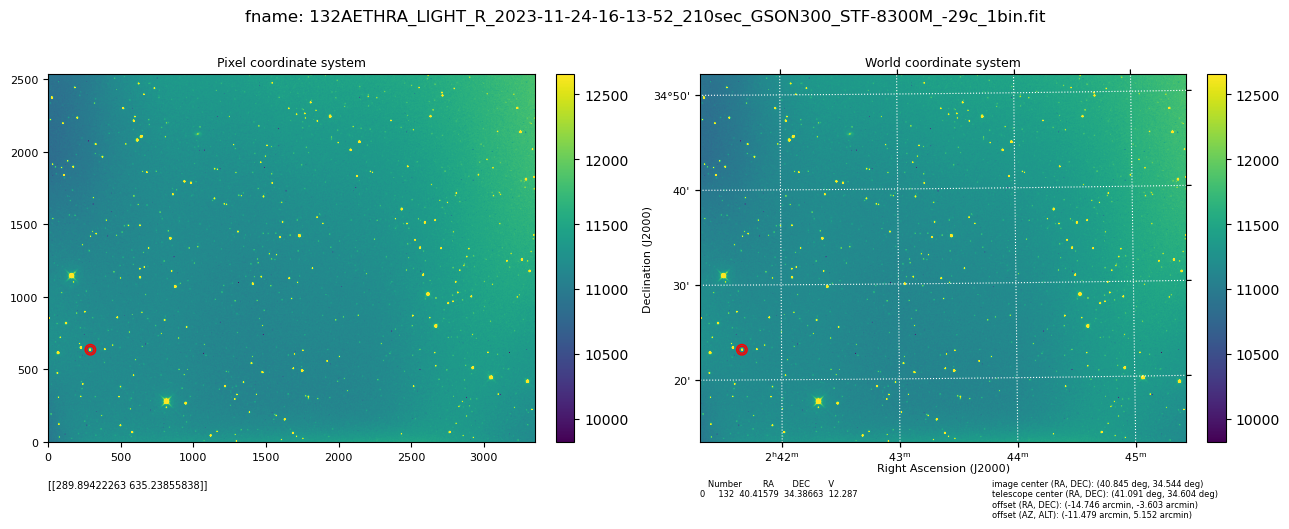

In [ ]:
fig_set = plt.figure(figsize=val_figsize)
ax1 = plt.subplot2grid((1,2), (0,0),
                    fig=fig_set)
im1 = _astro_utilities.zimshow(ax1, hdul[0].data, )
ax1.set_title('Pixel coordinate system', fontsize=9)
ax1.tick_params(labelsize=8)
plt.colorbar(im1, ax = ax1, fraction=val_fraction, pad=0.04)

ax2 = plt.subplot2grid((1,2), (0,1),
                    projection=wcs,
                    fig=fig_set)
im2 = _astro_utilities.zimshow(ax2, hdul[0].data, )
ax2.set_title('World coordinate system', fontsize=9)
ax2.coords.grid(True, color='white', ls=':')
ax2.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
ax2.coords['ra'].set_ticklabel_position('bl')
ax2.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
ax2.coords['dec'].set_ticklabel_position('bl')
ax2.coords['ra'].set_major_formatter('hh:mm')
ax2.coords['dec'].set_major_formatter('dd:mm')
ax2.coords['ra'].display_minor_ticks(True)
ax2.coords['dec'].display_minor_ticks(True)
ax2.coords['ra'].set_minor_frequency(1)
ax2.coords['dec'].set_minor_frequency(1)
ax2.tick_params(labelsize=8)

if df_targ_eph.empty:
    pass
else:
    targ_ap = CAp(pos_targ_init,
            r=R_AP, 
            )
    targ_an = CAn(pos_targ_init,
            r_in=R_IN,
            r_out=R_OUT)
    
    #targ_ap.plot(ax1, color="r")
    targ_an.plot(ax1, color="r")
    #targ_ap.plot(ax2, color="r")
    targ_an.plot(ax2, color="r")

    ax1.annotate(f"{pos_targ_init}",
            xy=(0, 0), xytext=(0, -0.1),
            xycoords='axes fraction',
            va='top', ha='left',
            fontsize=7)

    ax2.annotate(f"{df_targ_eph[['Number', 'RA', 'DEC', 'V']]}",
            xy=(0, 0), xytext=(0, -0.1),
            xycoords='axes fraction',
            va='top', ha='left',
            fontsize = 6)
plt.colorbar(im2, ax = ax2, fraction=val_fraction, pad=0.04)
plt.suptitle(f"fname: {fpath.name}")

ax2.annotate(f"image center (RA, DEC): ({cent_coord.ra:.03f}, {cent_coord.dec:.03f})\ntelescope center (RA, DEC): ({hdul[0].header['RA']*u.deg:.03f}, {hdul[0].header['DEC']*u.deg:.03f})\noffset (RA, DEC): ({offset_RA:.03f}, {offset_DEC:.03f})\noffset (AZ, ALT): ({offset_AZ:.03f}, {offset_ALT:.03f})",
            xy=(0, 0), xytext=(0.6, -0.1),
            xycoords='axes fraction',
            va='top', ha='left',
            fontsize = 6)
plt.tight_layout()
plt.savefig(f"{ASTRESULTDIR/fpath.stem}_AST_Mag{Mag_UP}.png")
plt.show()
plt.close()

In [ ]:
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

FWHM = FWHM_INIT
avg, med, std = sigma_clipped_stats(hdul[0].data)  # by default, 3-sigma 5-iteration.
thresh = 5. * std

DAOfind = DAOStarFinder(
                        fwhm = FWHM,
                        threshold = thresh,
                        # sharplo = 0.2, sharphi = 1.0,  # default values: sharplo=0.2, sharphi=1.0,
                        # roundlo = 0, roundhi = 1.0,  # default values -1 and +1
                        # sigma_radius = 3,           # default values 1.5
                        # ratio = 1.0,                  # 1.0: circular gaussian
                        # exclude_border = True         # To exclude sources near edges
                        )

DAOfound = DAOfind(hdul[0].data)
print("len(DAOfound) :",len(DAOfound))
print(DAOfound.colnames)
DAOfound
DAOfound.write(f"{ASTRESULTDIR/fpath.stem}_DAOStarfinder_fwhm_{FWHM}.csv",
                            overwrite = True,
                            format='ascii.fast_csv')
df_DAO = DAOfound.to_pandas()
print(type(df_DAO))
df_DAO

import numpy as np
pos = np.transpose((DAOfound['xcentroid'], DAOfound['ycentroid']))

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
apert = CAp(pos, r=R_AP)
#apert
annul = CAn(positions=pos, r_in= R_IN, r_out=R_OUT)
#annul

from astropy.wcs import WCS

wcs = WCS(hdul[0].header)
print("wcs :", wcs)
print("type(wcs) :", type(wcs))
print("dir(wcs) :", dir(wcs))

wcs.pixel_n_dim

fig_set = plt.figure(figsize=val_figsize)

ax1 = plt.subplot2grid((1,2), (0,0),
                    fig=fig_set)
im1 = _astro_utilities.zimshow(ax1, hdul[0].data, )
ax1.set_title('Pixel coordinate system', fontsize=9)
ax1.tick_params(labelsize=8)

ax2 = plt.subplot2grid((1,2), (0,1),
                    projection=wcs,
                    fig=fig_set)
im2 = _astro_utilities.zimshow(ax2, hdul[0].data, )
ax2.set_title('World coordinate system', fontsize=9)
ax2.coords.grid(True, color='white', ls=':')
ax2.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
ax2.coords['ra'].set_ticklabel_position('bl')
ax2.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
ax2.coords['dec'].set_ticklabel_position('bl')
ax2.coords['ra'].set_major_formatter('hh:mm')
ax2.coords['dec'].set_major_formatter('dd:mm')
ax2.coords['ra'].display_minor_ticks(True)
ax2.coords['dec'].display_minor_ticks(True)
ax2.coords['ra'].set_minor_frequency(2)
ax2.coords['dec'].set_minor_frequency(2)
ax2.tick_params(labelsize=8)

annul.plot(ax1, color="r")
annul.plot(ax2, color="r")

cbar1 = plt.colorbar(im1, ax = ax1, fraction=val_fraction, pad=0.04)
cbar2 = plt.colorbar(im2, ax = ax2, fraction=val_fraction, pad=0.04, )
cbar1.ax.tick_params(labelsize=8)
cbar2.ax.tick_params(labelsize=8)

plt.suptitle(f"fname: {fpath.name}\n Result of DAOFinder", fontsize=10,)

ax1.annotate(f'FWHM: {FWHM}', fontsize=8,
    xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

ax1.annotate(f'Sky threshold: {thresh:.02f}', fontsize=8,
    xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

ax1.annotate(f'Number of star(s): {len(DAOfound)}', fontsize=8,
    xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{ASTRESULTDIR/fpath.stem}_DAOStarfinder_fwhm_{FWHM}.png")

plt.show()
plt.close()

len(DAOfound) : 609
['id', 'xcentroid', 'ycentroid', 'sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']
<class 'pandas.core.frame.DataFrame'>
wcs : WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 40.8454858909  34.5444121701  
CRPIX : 1676.5  1266.5  
CD1_1 CD1_2  : 0.000254742145746  2.58398203603e-06  
CD2_1 CD2_2  : -2.57763941841e-06  0.000254822602597  
NAXIS : 3352  2532
type(wcs) : <class 'astropy.wcs.wcs.WCS'>
dir(wcs) : ['__abstractmethods__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_all_pix2world', '_all_world2pix', '_array_conver

Set MJD-AVG to 60272.677517 from DATE-AVG'. [astropy.wcs.wcs]


In [ ]:
df_targ_eph

,Number,Name,RA_1,DEC_1,Type,V_1,posunc,centerdist,RA_rate_1,DEC_rate_1,...,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
0,10073,Peterhiscocks,20.463744,15.726272,MB>Inner,16.7,0.033,496.203,-29.9518,-21.881,...,6.7664,0.000003,0.1,0.35,0.000045,343.6181,4.591002,5.2002,22.6914,5.0448


In [ ]:
if df_targ_eph.empty:
    pass
else:
    
    # Initialize PanSTARRS1 class
    q = ypu.PanSTARRS1(
        ra=cent_coord.ra.value,
        dec=cent_coord.dec.value,
        radius=rad,
        column_filters={"gmag":"11.0..15.0", "e_gmag":"<0.10"},
    )

    # Query to the website (VizieR)
    # This is where the most of the time is spent.
    q.query()

    # # Only select the stars within 50-pixel bezel in the FOV.
    q.select_xyinFOV(hdul[0].header,
                    #bezel=50
                    bezel=5*FWHM_INIT*PIX2ARCSEC
                    )

    # # Remove objects not suitable for differential photometry (see description below)
    q.drop_for_diff_phot(drop_by_Kron=True)

    q_stars_orig = q.queried.copy()
    pos_stars_orig = np.array([q_stars_orig["x"], q_stars_orig["y"]]).T
    q_stars_orig

    q.drop_star_groups(crit_separation = 6 * FWHM_INIT)
    q_stars_diropped = q.queried.copy()

    q_stars = q.queried.copy()
    #pos_sky_targ_init, pos_pix_targ_init

    pos_stars = np.array([q_stars["x"], q_stars["y"]]).T

    df_stars = q_stars_diropped.to_pandas()

/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysphotutilpy/queryutil.py:716: UserWarning: ra is not astropy Quantity: Assuming deg unit
  warn(f"{k} is not astropy Quantity: Assuming deg unit")
/home/guitar79/anaconda3/envs/astro_Python_env/lib/python3.11/site-packages/ysphotutilpy/queryutil.py:716: UserWarning: dec is not astropy Quantity: Assuming deg unit
  warn(f"{k} is not astropy Quantity: Assuming deg unit")
Set MJD-AVG to 60272.677517 from DATE-AVG'. [astropy.wcs.wcs]


103 objects remaining:  23 masked out of 126 based on [27.845775 27.845775]-pixel bezel.
 94 objects remaining:   9 masked out of 103 based on f_objID ([0, 1, 2, 3, 5, 7, 8, 9, 10, 23, 24]).
 67 objects remaining:  27 masked out of  94 based on the Kron magnitude criterion.
 58 objects remaining:   9 masked out of  67 based on DAOGROUP with 36.000-pixel critical separation..


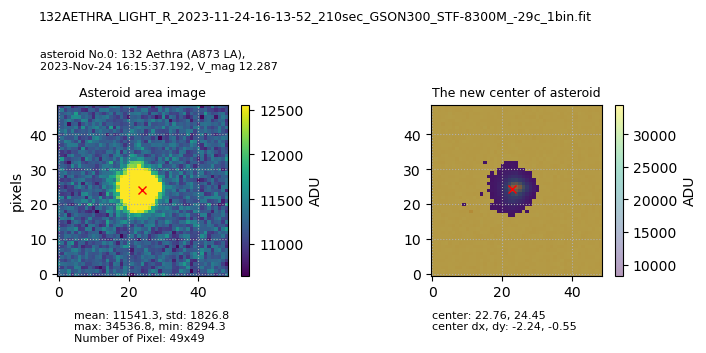

In [ ]:
for idx, row in df_targ_eph.iterrows():
    #try: 
    ASTNAME = row['targetname']
    cutsizes = 49
    #1. cut asteroia area
    #print(i)
    try :
        cut_hdu = Cutout2D(
                    data = hdul[0].data,
                    position = (pos_targ_init[idx]),
                    size=(cutsizes, cutsizes) #cut ccd
                    )
        avg, med, std = sigma_clipped_stats(cut_hdu.data)  # by default, 3-sigma 5-iteration.

        fig_set = plt.figure(figsize=(8, 5.5))
        
        ax11 = plt.subplot2grid((2, 2), (0,0),
                    fig=fig_set)
        im11 = _astro_utilities.zimshow(ax11, cut_hdu.data)
        ax11.plot(round(cutsizes/2), round(cutsizes/2), 'rx')
        ax11.set_ylabel('pixels')
        ax11.grid(ls=':')
        ax11.set_title(f'Asteroid area image', fontsize=9)
        ax11.annotate(   f"mean: {np.mean(cut_hdu.data):.01f}, std: {np.std(cut_hdu.data):.01f} \nmax: {np.max(cut_hdu.data):.01f}, min: {np.min(cut_hdu.data):.01f} \nNumber of Pixel: {np.shape(cut_hdu.data)[0]:.0f}x{np.shape(cut_hdu.data)[1]:.0f}",
            xy=(0, 0), xytext=(0.1, -0.20),
            xycoords='axes fraction',
            va='top', ha='left',
            fontsize=8)
        plt.colorbar(im11,
                    ax=ax11,
                    label="ADU",
                    fraction=0.0455, pad=0.04)
        #print("Image size is: ", cut_hdu.data.shape)

        #2. Get center dx, dy
        thresh_3sig = med + 3 * std
        mask_3sig = (cut_hdu.data < thresh_3sig)
        center = centroid_com(
                    data = cut_hdu.data,
                    mask = mask_3sig
                    )

        centerdx = center[0] - ((cutsizes+1)/2)
        centerdy = center[1] - ((cutsizes+1)/2)
        # print("type(center):", type(center))
        # print("center:", center)
        # print("center dx, dy:", centerdx, centerdy)

        ax12 = plt.subplot2grid((2,2), (0,1),
                    fig=fig_set)
        ax12.grid(ls=':')
        ax12.set_title(f'The new center of asteroid', fontsize=9)
        im12 = ax12.imshow(mask_3sig.astype(int),
            origin="lower")
        im12 = ax12.imshow(cut_hdu.data,
                alpha=0.4,
                origin="lower")
        ax12.plot(*center, 'rx')
        ax12.annotate(f"center: {center[0]:.02f}, {center[1]:.02f}\ncenter dx, dy: {centerdx:.02f}, {centerdy:.02f}",
                xy=(0, 0), xytext=(0.01, -0.20),
                xycoords='axes fraction',
                va='top', ha='left',
                fontsize=8)
        
        ax11.annotate(f"asteroid No.{i}: {row['targetname']}, \n{row['datetime_str']}, V_mag {row['V']}",
                xy=(1, 0), xytext=(-0.1, 1.33),
                xycoords='axes fraction',
                va='top', ha='left',
                fontsize=8)
        
        plt.colorbar(im12,
                    ax=ax12,
                    label="ADU",
                    fraction=0.0455, pad=0.04)
        plt.suptitle(f"{fpath.name}", 
                    fontsize=9)
        
        plt.tight_layout()
        plt.savefig(f"{ASTRESULTDIR/fpath.stem}_AST_Mag{Mag_UP}_{ASTNAME}.png")
        #plt.show()
        # plt.close()
    except : 
        continue

<class 'astropy.table.table.QTable'>


/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_3

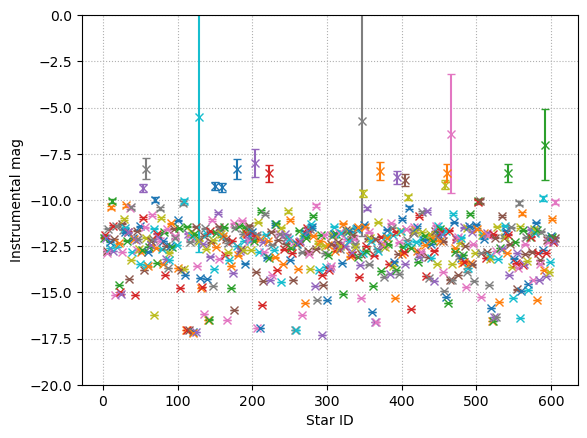

In [ ]:
from photutils.aperture import aperture_photometry as apphot
apphot_result = apphot(hdul[0].data, apert, method='center')
print(type(apphot_result))
apphot_result
df_apphot = apphot_result.to_pandas()
df_apphot
ap_area   = apert.area

# since our `annul` has many elements,
mask_apert = (apert.to_mask(method='center'))
mask_annul = (annul.to_mask(method='center'))

mag_ann  = np.zeros(len(apphot_result))
merr_ann = np.zeros(len(apphot_result))

#Returns magnitude from flux.
def mag_inst(flux, ferr):
    m_inst = -2.5 * np.log10(flux)
    merr   = 2.5/ np.log(10) * ferr / flux
    return m_inst, merr

fig, ax = plt.subplots()

for i in range(len(apphot_result)):
    annul_weighted = mask_annul[i].multiply(hdul[0].data)
    sky_non0   = np.nonzero(annul_weighted)
    sky_pixel  = annul_weighted[sky_non0]
    msky, sky_std, nsky, nrej = _astro_utilities.sky_fit(sky_pixel, method='mode', 
                                                        mode_option='sex')

    flux_star = apphot_result['aperture_sum'][i] - msky * ap_area  # total - sky

    flux_err  = np.sqrt(apphot_result['aperture_sum'][i] * gain    # Poissonian (star + sky)
                        + ap_area * rdnoise**2 # Gaussian
                        + (ap_area * (gain * sky_std))**2 / nsky )

    mag_ann[i], merr_ann[i] = mag_inst(flux_star, flux_err)
    # print(i, msky, sky_std, nsky, nrej)
    # print(i, mag_ann[idx], merr_ann[idx])
    try:
        ax.errorbar(i, mag_ann[i], yerr=merr_ann[i],
                    marker='x',
                    #ms=10,
                    capsize=3)
    except:
        continue

ax.invert_yaxis()
ax.set_ylim(ymin=-20, ymax=0)

plt.xlabel('Star ID')
plt.ylabel('Instrumental mag')
plt.grid(ls=':')

plt.savefig(f"{ASTRESULTDIR}/{fpath.name}_stars_IM.png")
# plt.show()
# plt.close()

/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_388440/250357804.py:18: RuntimeWarning: invalid value encountered in log10
  m_inst = -2.5 * np.log10(flux)
/tmp/ipykernel_3

len(phot_targ) : 1


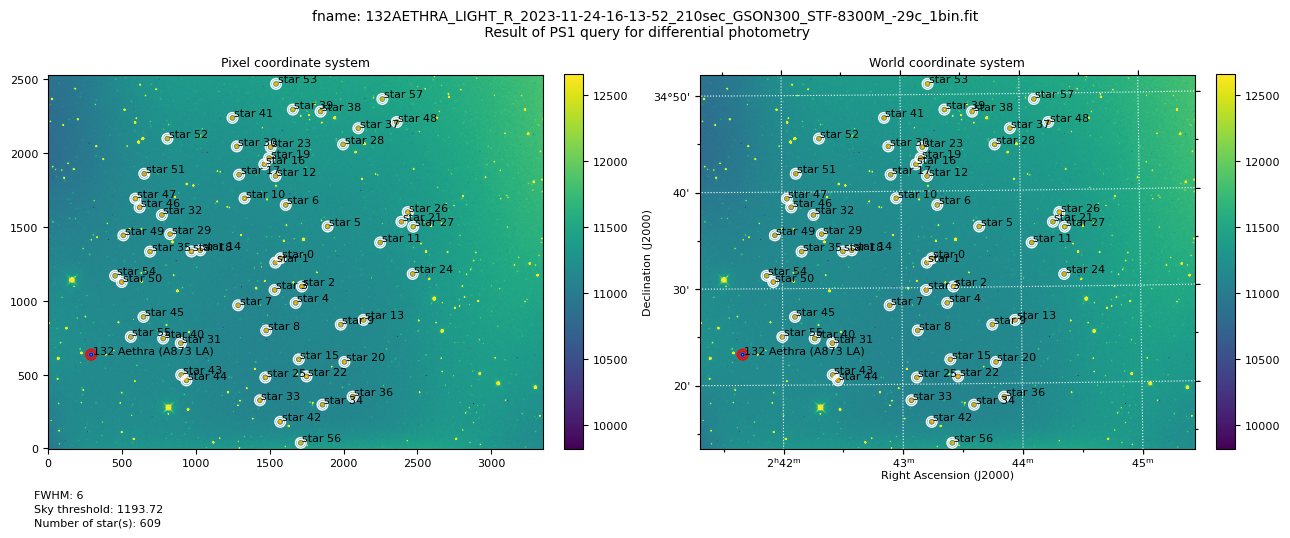

In [ ]:
for i, row in df_apphot.iterrows():
    annul_weighted = mask_annul[i].multiply(hdul[0].data)
    sky_non0   = np.nonzero(annul_weighted)
    sky_pixel  = annul_weighted[sky_non0]
    msky, sky_std, nsky, nrej = _astro_utilities.sky_fit(sky_pixel, method='mode', mode_option='sex')

    flux_star = apphot_result['aperture_sum'][i] - msky * ap_area  # total - sky

    flux_err  = np.sqrt(apphot_result['aperture_sum'][i] * gain    # Poissonian (star + sky)
                        + ap_area * rdnoise**2 # Gaussian
                        + (ap_area * (gain * sky_std))**2 / nsky )

    mag_ann, merr_ann = mag_inst(flux_star, flux_err)
    df_apphot.loc[i, 'msky'] = msky
    df_apphot.loc[i, 'sky_std'] = sky_std
    df_apphot.loc[i, 'nsky'] = nsky
    df_apphot.loc[i, 'nrej'] = nrej
    df_apphot.loc[i, 'flux_star'] = flux_star
    df_apphot.loc[i, 'flux_err'] = flux_err
    df_apphot.loc[i, 'mag_inst'] = mag_ann
    df_apphot.loc[i, 'merr_inst'] = merr_ann

df_apphot.to_csv(f"{ASTRESULTDIR}/{fpath.stem}_m_inst.csv")
#df_apphot


# fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

# im = _astro_utilities.zimshow(axs, hdul[0].data)

# targ_an.plot(axs, color="r")
# targ_ap.plot(axs, color="b")
# axs.text(pos_targ_init[idx][0]+10, pos_targ_init[idx][1]+10, f"ASTNAME", fontsize=8)

# phot_targ = ypu.apphot_annulus(hdul[0].data, targ_ap, targ_an, error=yfu.errormap(hdul[0].data))
# phot_targ

# _phot_stars = []

# for i, row in df_stars.iterrows():
#     pos_star = SkyCoord(row["RAJ2000"], row["DEJ2000"],
#                         **SKYC_KW).to_pixel(wcs, origin=0, mode='wcs')
#     ap = CAp([pos_star[0], pos_star[1]], r=R_AP)
#     an = CAn([pos_star[0], pos_star[1]], r_in=R_IN, r_out=R_OUT)
#     _phot_star = ypu.apphot_annulus(hdul[0].data, ap, an, error=yfu.errormap(hdul[0].data))
#     _phot_star["Rmag"] = row["rmag"]
#     _phot_star["e_Rmag"] = row["e_rmag"]
#     _phot_star["grcolor"] = row["gmag"] - row["rmag"] #row["grcolor"]
#     _phot_star["e_grcolor"] = row["e_gmag"] + row["e_rmag"]
#     _phot_star["id"] = i
#     _phot_star["objID"] = int(row["objID"])
#     _phot_stars.append(_phot_star)
#     axs.text(pos_star[0]+10, pos_star[1]+10, f"star {i}", fontsize=8)
#     ap.plot(axs, color="orange")
#     an.plot(axs, color="w")
# plt.title(f"{fpath.name}")

# plt.tight_layout()
# plt.savefig(f"{ASTRESULTDIR}/{fpath.stem}_asteroid_PS1_query.png")
# # plt.show()
# # plt.close()

fig_set = plt.figure(figsize=val_figsize)

ax1 = plt.subplot2grid((1,2), (0,0),
                    fig=fig_set)
im1 = _astro_utilities.zimshow(ax1, hdul[0].data, )
ax1.set_title('Pixel coordinate system', fontsize=9)
ax1.tick_params(labelsize=8)

ax2 = plt.subplot2grid((1,2), (0,1),
                    projection=wcs,
                    fig=fig_set)
im2 = _astro_utilities.zimshow(ax2, hdul[0].data, )

phot_targ = ypu.apphot_annulus(hdul[0].data, targ_ap, targ_an, error=yfu.errormap(hdul[0].data))
print("len(phot_targ) :", len(phot_targ))

_phot_stars = []

for i, row in df_stars.iterrows():
    pos_star = SkyCoord(row["RAJ2000"], row["DEJ2000"],
                        **SKYC_KW).to_pixel(wcs, origin=0, mode='wcs')
    ap = CAp([pos_star[0], pos_star[1]], r=R_AP)
    an = CAn([pos_star[0], pos_star[1]], r_in=R_IN, r_out=R_OUT)
    _phot_star = ypu.apphot_annulus(hdul[0].data, ap, an, error=yfu.errormap(hdul[0].data))
    _phot_star["Rmag"] = row["rmag"]
    _phot_star["e_Rmag"] = row["e_rmag"]
    _phot_star["grcolor"] = row["gmag"] - row["rmag"] #row["grcolor"]
    _phot_star["e_grcolor"] = row["e_gmag"] + row["e_rmag"]
    _phot_star["id"] = i
    _phot_star["objID"] = int(row["objID"])
    _phot_stars.append(_phot_star)
    ax1.text(pos_star[0]+10, pos_star[1]+10, f"star {i}", fontsize=8)
    ap.plot(ax1, color="orange")
    an.plot(ax1, color="w")
    ax2.text(pos_star[0]+10, pos_star[1]+10, f"star {i}", fontsize=8)
    ap.plot(ax2, color="orange")
    an.plot(ax2, color="w")

ax2.set_title('World coordinate system', fontsize=9)
ax2.coords.grid(True, color='white', ls=':')
ax2.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
ax2.coords['ra'].set_ticklabel_position('bl')
ax2.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
ax2.coords['dec'].set_ticklabel_position('bl')
ax2.coords['ra'].set_major_formatter('hh:mm')
ax2.coords['dec'].set_major_formatter('dd:mm')
ax2.coords['ra'].display_minor_ticks(True)
ax2.coords['dec'].display_minor_ticks(True)
ax2.coords['ra'].set_minor_frequency(2)
ax2.coords['dec'].set_minor_frequency(2)
ax2.tick_params(labelsize=8)

targ_an.plot(ax1, color="r")
targ_ap.plot(ax1, color="b")
targ_an.plot(ax2, color="r")
targ_ap.plot(ax2, color="b")
ax1.text(pos_targ_init[idx][0]+10, pos_targ_init[idx][1]+10, f"{ASTNAME}", fontsize=8)
ax2.text(pos_targ_init[idx][0]+10, pos_targ_init[idx][1]+10, f"{ASTNAME}", fontsize=8)

cbar1 = plt.colorbar(im1, ax = ax1, fraction=val_fraction, pad=0.04)
cbar2 = plt.colorbar(im2, ax = ax2, fraction=val_fraction, pad=0.04, )
cbar1.ax.tick_params(labelsize=8)
cbar2.ax.tick_params(labelsize=8)

plt.suptitle(f"fname: {fpath.name}\n Result of PS1 query for differential photometry", fontsize=10,)

ax1.annotate(f'FWHM: {FWHM}', fontsize=8,
    xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

ax1.annotate(f'Sky threshold: {thresh:.02f}', fontsize=8,
    xy=(0, 0), xytext=(-10, -40), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

ax1.annotate(f'Number of star(s): {len(DAOfound)}', fontsize=8,
    xy=(0, 0), xytext=(-10, -50), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{ASTRESULTDIR}/{fpath.stem}_asteroid_PS1_query_{ASTNAME}.png")

# plt.show()
# plt.close()

In [ ]:
df_eph

,targetname,datetime_str,datetime_jd,H,G,solar_presence,flags,RA,DEC,RA_app,...,r_3sigma,r_rate_3sigma,SBand_3sigma,XBand_3sigma,DoppDelay_3sigma,true_anom,hour_angle,alpha_true,PABLon,PABLat
0,132 Aethra (A873 LA),2023-Nov-24 16:15:37.192,2.460273e+06,8.95,0.15,,m,40.41579,34.38663,40.78408,...,19.0626,0.000002,0.05,0.19,0.000127,258.3651,2.232641,8.8061,51.4614,14.2555


   id      xcenter      ycenter  aperture_sum  aperture_sum_err          msky  \
0   0  1572.559689  1288.445062  3.000392e+06       1732.163918  11162.411082   
0   1  1538.085341  1259.199789  2.942890e+06       1715.485423  11153.242724   
0   2  1718.060175  1097.479120  3.006323e+06       1733.875029  11152.652806   
0   3  1533.410577  1073.773357  2.950270e+06       1717.634871  11125.062856   
0   4  1675.948293   986.082589  3.018235e+06       1737.306765  11138.447601   
0   5  1892.420775  1504.031446  3.045416e+06       1745.112054  11226.857101   
0   6  1608.698218  1649.901309  2.979343e+06       1726.077265  11214.465687   
0   7  1286.285069   970.220371  2.942702e+06       1715.430595  11123.655184   
0   8  1476.270197   799.384474  2.944256e+06       1715.883569  11114.332723   
0   9  1981.478173   839.100483  2.973001e+06       1724.239206  11144.497561   
0  10  1329.470375  1694.958231  2.980260e+06       1726.342974  11209.647376   
0  11  2248.318576  1395.436

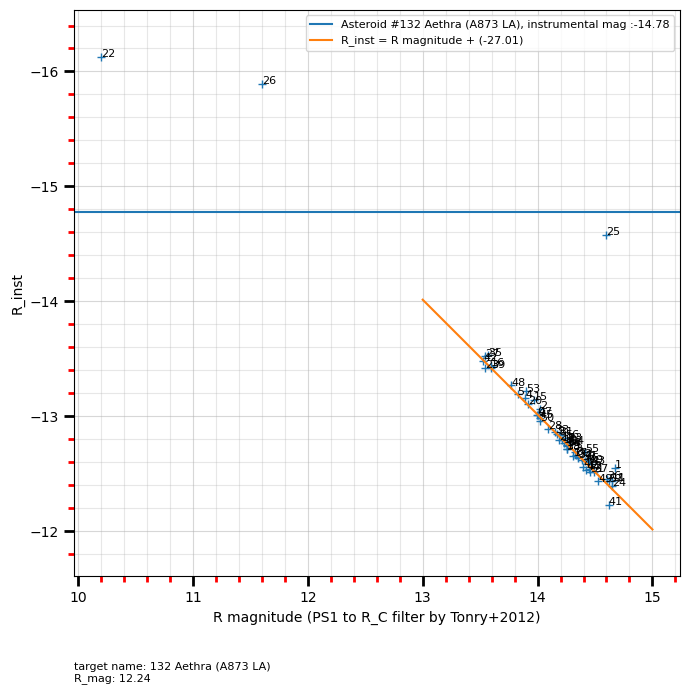

In [ ]:
df_phot_stars = pd.concat(_phot_stars)
df_phot_stars = df_phot_stars.dropna()
#phot_stars = phot_stars.loc[phot_stars["objID"] != 125240299358089744].copy()  # star 15
# SEE THE LAST CELL IN THIS FILE FOR DESCRIPTION
#df_phot_stars = df_phot_stars.set_index('id', drop=True)
df_phot_stars
#print(phot_targ)
print(df_phot_stars)
#try: 
fig, axs = plt.subplots(1, 1, figsize=(7, 7),
    sharex=False, sharey=False, gridspec_kw=None)

_xx = np.linspace(13, 15)
axs.plot(df_phot_stars["Rmag"], df_phot_stars["mag"], '+')
axs.axhline(phot_targ["mag"][idx],
            label=f"Asteroid #{ASTNAME}, instrumental mag :{float(phot_targ['mag'][idx]):.01f}")
axs.plot(_xx, _xx + np.median(df_phot_stars['mag'] - df_phot_stars['Rmag']),
        label=f"R_inst = R magnitude + ({np.median(df_phot_stars['mag'] - df_phot_stars['Rmag']):.01})")

for _, row in df_phot_stars.iterrows():
    axs.text(row["Rmag"], row["mag"], int(row["id"]), fontsize=8)

axs.set(
    xlabel="R magnitude (PS1 to R_C filter by Tonry+2012)",
    ylabel="R_inst"
)
axs.axis('equal')
axs.grid(which = "major", alpha=0.5)
axs.grid(':', which = "minor", alpha=0.3)
axs.invert_yaxis()
axs.minorticks_on()
axs.tick_params(which='both', width=2)
axs.tick_params(which='major', length=7)
axs.tick_params(which='minor', length=4, color='r')
axs.legend(fontsize="8", 
        #loc ="ower right"
        )

axs.annotate(f"target name: {df_eph['targetname'][0]}\nR_mag: {np.median(df_phot_stars['Rmag'] - df_phot_stars['mag'])+ phot_targ['mag'][0]:.02f}",
            fontsize=8, xy=(0, 0), xytext=(0, -0.15), va='top', ha='left',
            xycoords='axes fraction')

plt.tight_layout()
plt.savefig(f"{ASTRESULTDIR}/{fpath.stem}_standardization_{ASTNAME}.png")
# plt.show()
# plt.close()

# except Exception as err: 
#     print("Err :", err)
#     continue